## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Suppress ta warnings
import warnings
warnings.filterwarnings("ignore")

# Auto reload local files
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if '../src' not in sys.path:
    sys.path.insert(0, '../src')

In [2]:
# Read SPY csv, define config
watchlist = list(pd.read_csv('../data/watchlist.csv', header=0)['symbol'])
spy_constituents = list(pd.read_csv('../../data/spy_constituents.csv', header=0)['Symbol'])
random.shuffle(spy_constituents)

tickers = spy_constituents
start_date = "2000-01-01"
end_date = "2025-01-01"
predict_window = 30

## Sync & Load Data, Create Indicators

In [3]:
# Load the data from db
from sklearn.model_selection import train_test_split

import datastore as ds
from technical_signals import TechnicalSignalSet

ds.download_daily_candlesticks(tickers, start_date, end_date)
candlesticks = ds.get_daily_candlesticks(tickers, start_date, end_date)

Xs = []
ys = []

for ticker in tickers:
    try:
        technical_sigs = TechnicalSignalSet(candlesticks[ticker], predict_window)
        X, y, Xy_date = technical_sigs.to_xy()
        Xs.append(X)
        ys.append(y)
    except Exception as ex:
        print(f"Exception on {ticker}:")
        print(ex)

X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for KSU


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Date'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/sit

Error downloading daily candlesticks for BRK.B


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for PBCT


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for CERN


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Date'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/sit

Error downloading daily candlesticks for BF.B


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for DISCA


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for BLL


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for WLTW


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for XLNX


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for INFO


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for VIAC


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/yahoo/daily.py", line 153, in _read_one_data
    data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
KeyError: 'HistoricalPriceStore'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/datastore.py", line 105, in download_daily_candlesticks
    data = pdr.DataReader(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/util/_decorators.py", line 207, in wrapper
    return func(*args, **kwargs)
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas_datareader/data.py", line 379, in DataReader
    ).read()
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10

Error downloading daily candlesticks for DISCK
Exception on KSU:
'high'
Exception on BRK.B:
'high'
Exception on PBCT:
'high'
Exception on BF.B:
'high'
Exception on DISCA:
'high'
Exception on WLTW:
'high'
Exception on XLNX:
'high'
Exception on INFO:
'high'
Exception on OGN:
Found array with 0 sample(s) (shape=(0, 58)) while a minimum of 1 is required by StandardScaler.
Exception on VIAC:
'high'
Exception on DISCK:
'high'


## Clean Data For Training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc


def round_batch_size(sample_count, approximately, leeway=None):
    """
    Round batch size to a more suitable value. This helps to avoid a
    problem where the final batch has a lot of samples, but not enough for
    a full batch, leading to many samples being thrown out.

    approximately: int, leeway: int
      decide on a chunk size around a number, with specified leeway
      (leeway defaults to `approximately // 10`).
    """
    if leeway is None:
        leeway = approximately // 10
    
    # Get the number of leftover samples if we use the suggested batch size
    best_leftover = sample_count - np.floor(sample_count / approximately) * approximately

    # Brute-force search for the value that yeilds the fewest leftovers
    # within the given leeway range.
    best_chunk_count = approximately
    for offset in range(-leeway, leeway):
        chunk_size = approximately + offset
        leftover = sample_count - np.floor(sample_count / chunk_size) * chunk_size
        if leftover < best_leftover:
            best_leftover = leftover
            best_chunk_count = chunk_size
    return best_chunk_count
            

batch_size = round_batch_size(X_train.shape[0], 1024, leeway=200)
n_features = X_train.shape[1]

# Convert X, y to torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train.reshape(y_train.shape[0], 1)).float()
y_test_tensor = torch.from_numpy(y_test.reshape(y_test.shape[0], 1)).float()

print(X_train_tensor.shape)
print('Batch size:', batch_size)

# Generators
training_set = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(training_set, shuffle=True, batch_size=batch_size)

validation_set = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(validation_set, shuffle=True, batch_size=batch_size)

# Release duplicated memory
try:
    del X
    del y
    del Xs
    del ys
    #del X_train
    #del X_test
    #del y_train
    #del y_test
    del X_train_tensor
    del X_test_tensor
    del y_train_tensor
    del y_test_tensor
except:
    pass
gc.collect()

torch.Size([2175106, 58])
Batch size: 894


0

## Create the NN model

In [5]:
n_outputs = 1

net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, n_outputs),
)

## Training

In [6]:
device = torch.device("cuda")

# Set device for model
net = net.to(device)

# Select optimizerand loss criteria
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 

# Training the model
for epoch in range(200):
    train_loss = 0.0
    
    # Training
    net.train()
    for local_batch, local_labels in dataloader_train:
        if local_batch.shape[0] != batch_size:
            print(f"Wrong train batch size. Skipping batch.\nThrowing away {local_batch.shape[0]} samples.")
            continue
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass: Compute predicted y by passing x to the model 
        y_pred = net(local_batch)
        # Compute and print loss 
        loss = criterion(y_pred, local_labels)
        # Zero gradients, perform a backward pass, update the weights. 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        # Update loss
        train_loss += loss.item()

    # Validation
    net.eval()
    valid_loss = 0.0
    for data, labels in dataloader_test:
        if data.shape[0] != batch_size:
            continue
        data, labels = data.to(device), labels.to(device)
        
        target = net(data)
        loss = criterion(target,labels)
        valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(dataloader_train)} \t\t Validation Loss: {valid_loss / len(dataloader_test)}')

Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 1 		 Training Loss: 0.9025679367824765 		 Validation Loss: 0.8592173812925353
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 2 		 Training Loss: 0.8475636370669846 		 Validation Loss: 0.8222504475320033
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 3 		 Training Loss: 0.8167996884812658 		 Validation Loss: 0.8040266009264214
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 4 		 Training Loss: 0.7938531270111401 		 Validation Loss: 0.7858624056328175
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 5 		 Training Loss: 0.7749578021987109 		 Validation Loss: 0.7680738194044247
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 6 		 Training Loss: 0.7596348607843786 		 Validation Loss: 0.7590700618980467
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 7 		 Training Loss: 0.7462917329741

Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 56 		 Training Loss: 0.5965926443932972 		 Validation Loss: 0.6255814945975016
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 57 		 Training Loss: 0.5957430571121766 		 Validation Loss: 0.6248209014419437
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 58 		 Training Loss: 0.5950947618670609 		 Validation Loss: 0.6260817545328954
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 59 		 Training Loss: 0.5939892037245907 		 Validation Loss: 0.6238396865452907
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 60 		 Training Loss: 0.5930449826828064 		 Validation Loss: 0.6244768999343695
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 61 		 Training Loss: 0.5922589425606716 		 Validation Loss: 0.6226579394451407
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 62 		 Training Loss: 0.591480

Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 111 		 Training Loss: 0.5647003019722936 		 Validation Loss: 0.6018494704897089
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 112 		 Training Loss: 0.5642209978576752 		 Validation Loss: 0.5985669519088065
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 113 		 Training Loss: 0.564369497993684 		 Validation Loss: 0.6012954596401185
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 114 		 Training Loss: 0.5636375112276931 		 Validation Loss: 0.6012490211531173
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 115 		 Training Loss: 0.5633040295581693 		 Validation Loss: 0.5987650516421296
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 116 		 Training Loss: 0.5627585004099883 		 Validation Loss: 0.5950831877168758
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 117 		 Training Loss: 0.

Epoch 165 		 Training Loss: 0.5494990339387903 		 Validation Loss: 0.5867714297401813
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 166 		 Training Loss: 0.549005396694753 		 Validation Loss: 0.5871557112812071
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 167 		 Training Loss: 0.5484593904890187 		 Validation Loss: 0.5878259220788645
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 168 		 Training Loss: 0.5482495679728987 		 Validation Loss: 0.5891499588655871
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 169 		 Training Loss: 0.5484281633854304 		 Validation Loss: 0.5861231285010198
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 170 		 Training Loss: 0.547892419635123 		 Validation Loss: 0.5875852593155795
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 171 		 Training Loss: 0.5475972280971516 		 Validation Loss: 0.5866541927175004
Wrong trai

Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 220 		 Training Loss: 0.5387406787156275 		 Validation Loss: 0.5807290312855743
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 221 		 Training Loss: 0.5386404705370854 		 Validation Loss: 0.5761158068974813
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 222 		 Training Loss: 0.5384653790646532 		 Validation Loss: 0.5793128494144411
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 223 		 Training Loss: 0.5382756408282549 		 Validation Loss: 0.5773576881534369
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 224 		 Training Loss: 0.5385670263378367 		 Validation Loss: 0.5801890654157299
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 225 		 Training Loss: 0.5380286954790231 		 Validation Loss: 0.578731848287952
Wrong train batch size. Skipping batch.
Throwing away 4 samples.
Epoch 226 		 Training Loss: 0.

## Backtest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

import torch.nn as nn

model = nn.Sequential(
    nn.Linear(58, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)

Ticker: CBRE


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/home/jared/.local/share/virtual

Error downloading daily candlesticks for CBRE
0 buy/sells performed - 0.0% of the time
Stock price change: 93.9980741871842%
ROI: nan%
{'cash': 10000, 'assets': 0, 'latest_price': 79.7300033569336, 'total_value': 10000.0, 'roi': nan}


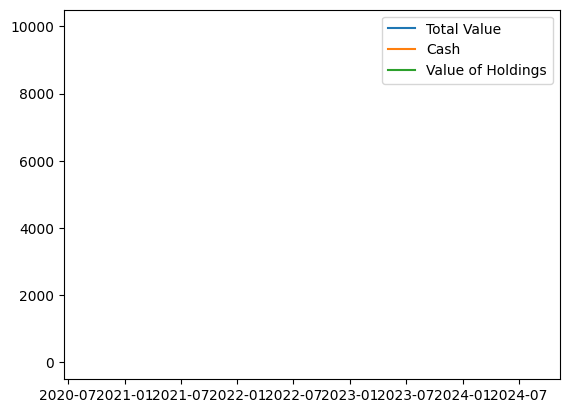

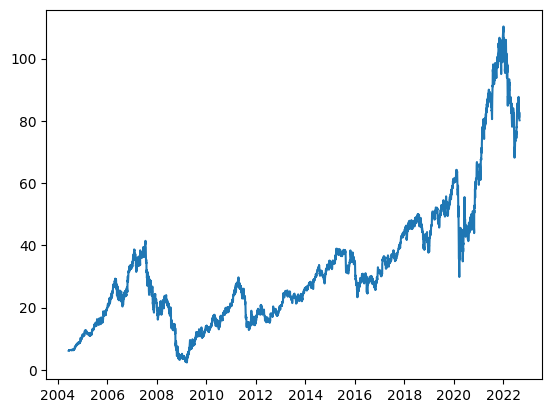

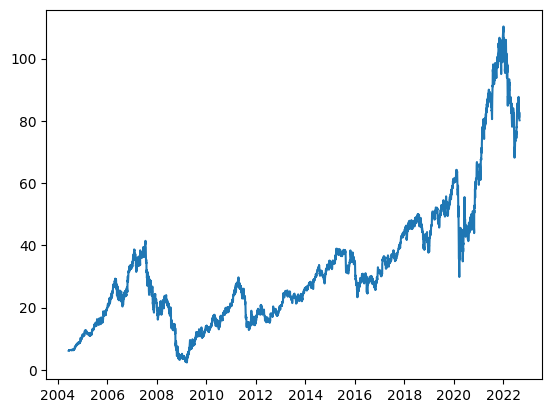

Ticker: CAG


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/home/jared/.local/share/virtual

Error downloading daily candlesticks for CAG
0 buy/sells performed - 0.0% of the time
Stock price change: -2.9241417194234915%
ROI: nan%
{'cash': 10000, 'assets': 0, 'latest_price': 34.79999923706055, 'total_value': 10000.0, 'roi': nan}


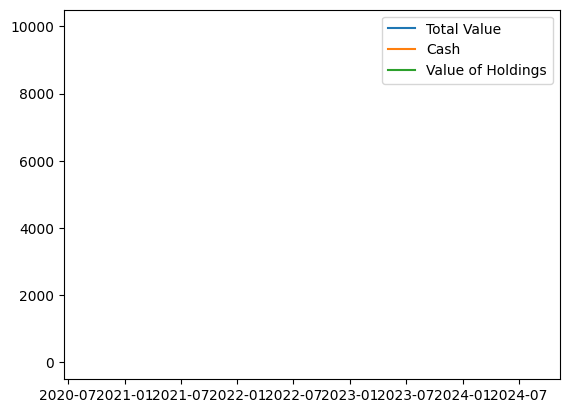

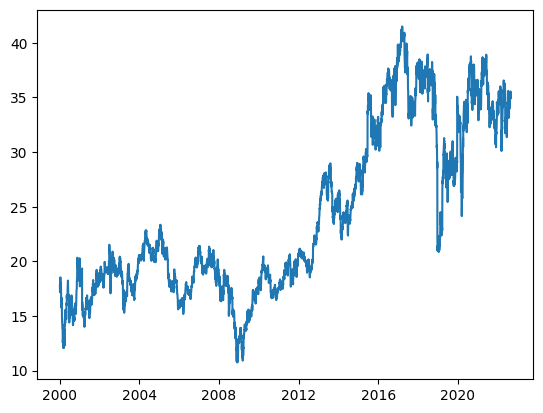

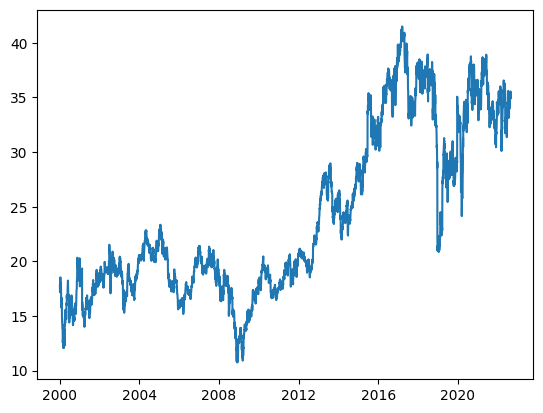

Ticker: TXN


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/home/jared/.local/share/virtual

Error downloading daily candlesticks for TXN
0 buy/sells performed - 0.0% of the time
Stock price change: 62.4102576686113%
ROI: nan%
{'cash': 10000, 'assets': 0, 'latest_price': 169.94000244140625, 'total_value': 10000.0, 'roi': nan}


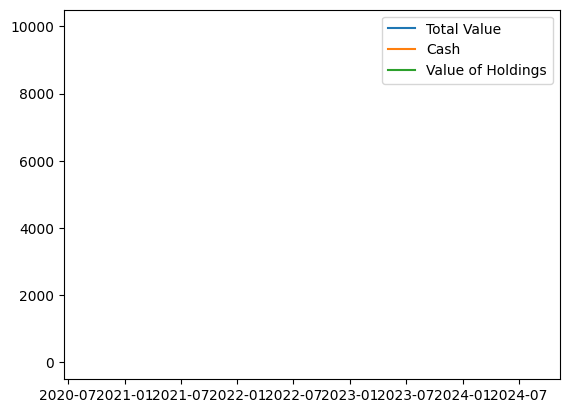

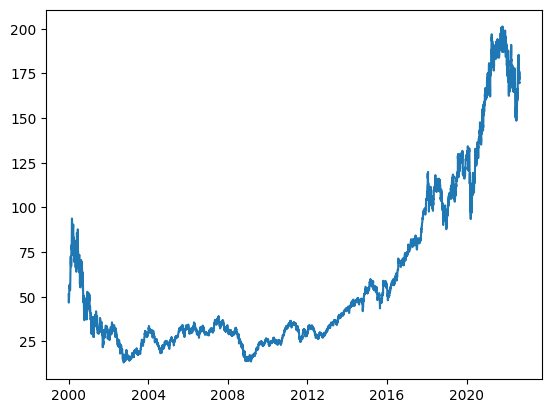

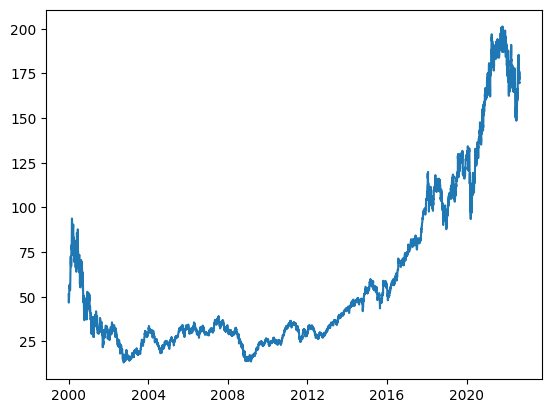

{'average_gainloss': 0.0,
 'results': {'CBRE': {'cash': 10000,
   'assets': 0,
   'latest_price': 79.7300033569336,
   'total_value': 10000.0,
   'roi': nan},
  'CAG': {'cash': 10000,
   'assets': 0,
   'latest_price': 34.79999923706055,
   'total_value': 10000.0,
   'roi': nan},
  'TXN': {'cash': 10000,
   'assets': 0,
   'latest_price': 169.94000244140625,
   'total_value': 10000.0,
   'roi': nan}}}

In [38]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import backtest as bt
from strategy import PretrainedModelStrategy, SignalModelStrategy
from technical_signals import TechnicalSignalSet
from sklearn.svm import SVR

random.shuffle(spy_constituents)

# LOAD PYTORCH MODEL FROM DB (HELL YEA)
model_env = ds.get_all_model_envs()[0]
model = model_env.hydrate_model()
net = model.model

# XXX temporary - need to rework concurrency to be suitable for CUDA
# (Must use `spawn` as opposed to `fork` based concurrency I believe - separate OS processes?)
net = net.to(torch.device('cpu'))

def predict(net):
    return lambda X:\
        net(torch.from_numpy(X).float().cpu()).detach().numpy()

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

#strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=0.95, bias=0.2)
strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=4., bias=0.)
#strategy = SignalModelStrategy(SVR(), lambda df: TechnicalSignalSet(df, predict_window=14), cutoff=1., bias=0.1)
bt.comprehensive_backtest(strategy, spy_constituents[:3], "2000-01-01", "2025-01-01", plot=True, train_test_ratio=0.8)

## Save Model

In [31]:
from predictive_model import PredictiveModel
from datetime import datetime
from model_env import ModelEnv

net = net.to(torch.device('cpu'))

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

model = PredictiveModel(net, "TorchMATI-300epoch-standardscaler", predict_window, datetime.now())
model.save()

model_env = ModelEnv.from_model(model, 'My First Test', [{'id': 'rsi'}], model_code=f"""
import torch.nn as nn

model = nn.Sequential(
    nn.Linear({n_features}, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)
""")

ds.save_model_envs([model_env])

## Generate and Store Predictions

In [9]:
from predict import predict_price_change
predictions = predict_price_change(model, df_to_signal_set, tickers[:10])
ds.save_predictions([p for t, p in predictions.items()])